## 1. IMPORT THƯ VIỆN

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from collections import Counter

# Kiểm tra GPU
print(f"TensorFlow Version: {tf.__version__}")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Cấu hình GPU memory growth để tránh OOM
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except RuntimeError as e:
        print(e)


TensorFlow Version: 2.15.0
Num GPUs Available:  0
TensorFlow Version: 2.15.0
Num GPUs Available:  0


## 2. CẤU HÌNH THAM SỐ TỐI ƯU

In [2]:
# Cấu hình cơ bản
IMG_SIZE = 256
BATCH_SIZE = 32  # Có thể tăng lên 64 nếu GPU đủ mạnh
EPOCHS_STAGE1 = 15  # Stage 1: Freeze base model
EPOCHS_STAGE2 = 15  # Stage 2: Fine-tune top layers
LEARNING_RATE_STAGE1 = 0.001
LEARNING_RATE_STAGE2 = 0.0001  # Nhỏ hơn cho fine-tuning
DATASET_PATH = "../Hocmaynangcao/Tomato/"

# Đường dẫn
train_dir = os.path.join(DATASET_PATH, 'Train')
val_dir = os.path.join(DATASET_PATH, 'Val')
test_dir = os.path.join(DATASET_PATH, 'Test')

# Cấu hình nâng cao
USE_MIXUP = True  # Sử dụng MixUp augmentation
USE_CLASS_WEIGHTS = True  # Xử lý imbalanced data
USE_ATTENTION = True  # Thêm attention mechanism
DROPOUT_RATE = 0.3  # Tăng dropout để giảm overfitting

print(f"Đọc dữ liệu từ: {os.path.abspath(DATASET_PATH)}")

Đọc dữ liệu từ: h:\nam4ki1\Hocmaynangcao\Tomato


## 3. DATA AUGMENTATION NÂNG CAO

In [3]:
# Load dữ liệu
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True,
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

# Lấy class names
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Số lượng lớp: {num_classes}")
print(f"Các lớp: {class_names}")

# Tính class weights cho imbalanced data
if USE_CLASS_WEIGHTS:
    # Đếm số lượng ảnh mỗi class
    class_counts = {}
    for class_name in class_names:
        class_path = os.path.join(train_dir, class_name)
        count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        class_counts[class_name] = count
    
    total_samples = sum(class_counts.values())
    class_weights = {i: total_samples / (num_classes * class_counts[class_name]) 
                     for i, class_name in enumerate(class_names)}
    
    print("\n📊 Class Distribution:")
    for i, (name, count) in enumerate(class_counts.items()):
        print(f"  {name}: {count} images (weight: {class_weights[i]:.3f})")
else:
    class_weights = None

Found 11114 files belonging to 6 classes.
Found 2495 files belonging to 6 classes.
Found 2495 files belonging to 6 classes.
Found 280 files belonging to 6 classes.
Found 280 files belonging to 6 classes.
Số lượng lớp: 6
Các lớp: ['Bacterial Spot', 'Early Blight', 'Healthy', 'Late Blight', 'Septoria Leaf Spot', 'Yellow Leaf Curl Virus']

📊 Class Distribution:
  Bacterial Spot: 1707 images (weight: 1.085)
  Early Blight: 1921 images (weight: 0.964)
  Healthy: 1926 images (weight: 0.961)
  Late Blight: 1851 images (weight: 1.000)
  Septoria Leaf Spot: 1745 images (weight: 1.061)
  Yellow Leaf Curl Virus: 1961 images (weight: 0.944)
Số lượng lớp: 6
Các lớp: ['Bacterial Spot', 'Early Blight', 'Healthy', 'Late Blight', 'Septoria Leaf Spot', 'Yellow Leaf Curl Virus']

📊 Class Distribution:
  Bacterial Spot: 1707 images (weight: 1.085)
  Early Blight: 1921 images (weight: 0.964)
  Healthy: 1926 images (weight: 0.961)
  Late Blight: 1851 images (weight: 1.000)
  Septoria Leaf Spot: 1745 images 

In [4]:
# Data Augmentation mạnh mẽ hơn
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Thêm vertical flip
    layers.RandomRotation(0.2),  # Tăng rotation range
    layers.RandomZoom(0.15),  # Tăng zoom range
    layers.RandomContrast(0.2),  # Tăng contrast
    layers.RandomBrightness(0.2),  # Thêm brightness augmentation
    layers.RandomTranslation(0.1, 0.1),  # Thêm translation
], name="data_augmentation")

# MixUp augmentation layer
class MixUp(tf.keras.layers.Layer):
    """MixUp: Trộn 2 ảnh và label với tỷ lệ ngẫu nhiên"""
    def __init__(self, alpha=0.2, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha

    def call(self, images, labels, training=None):
        if not training:
            return images, labels
        
        batch_size = tf.shape(images)[0]
        
        # Sample lambda từ beta distribution
        lam = tf.random.uniform([batch_size, 1, 1, 1], 0, 1)
        lam = tf.maximum(lam, 1 - lam)
        
        # Shuffle indices
        indices = tf.random.shuffle(tf.range(batch_size))
        
        # Mix images
        mixed_images = lam * images + (1 - lam) * tf.gather(images, indices)
        
        # Mix labels
        lam_labels = tf.squeeze(lam, axis=[2, 3])
        mixed_labels = lam_labels * labels + (1 - lam_labels) * tf.gather(labels, indices)
        
        return mixed_images, mixed_labels

mixup_layer = MixUp(alpha=0.2) if USE_MIXUP else None

# Tối ưu hóa hiệu năng
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("✅ Data augmentation setup complete")


✅ Data augmentation setup complete
✅ Data augmentation setup complete


## 4. KIẾN TRÚC MODEL TỐI ƯU VỚI ATTENTION

In [5]:
# Spatial Attention Module
class SpatialAttention(tf.keras.layers.Layer):
    """Attention mechanism để model tập trung vào vùng quan trọng"""
    def __init__(self, kernel_size=7, **kwargs):
        super().__init__(**kwargs)
        self.kernel_size = kernel_size
        
    def build(self, input_shape):
        self.conv = layers.Conv2D(
            filters=1,
            kernel_size=self.kernel_size,
            padding='same',
            activation='sigmoid',
            use_bias=False
        )
        super().build(input_shape)
        
    def call(self, inputs):
        # Average pooling và max pooling theo channel
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        
        # Concat
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        
        # Tạo attention map
        attention = self.conv(concat)
        
        # Áp dụng attention
        return inputs * attention

def build_optimized_model(num_classes):
    """Xây dựng model tối ưu với attention và architecture improvements"""
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Data augmentation (chỉ áp dụng khi training)
    x = data_augmentation(inputs)
    
    # Load EfficientNetB0 pre-trained
    base_model = EfficientNetB0(
        include_top=False, 
        weights='imagenet', 
        input_tensor=x
    )
    
    # STAGE 1: Freeze base model
    base_model.trainable = False
    
    # Lấy features từ base model
    x = base_model.output
    
    # Thêm Spatial Attention
    if USE_ATTENTION:
        x = SpatialAttention(kernel_size=7)(x)
    
    # Global pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    # Dense layers với BatchNorm và Dropout
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(DROPOUT_RATE)(x)
    
    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(DROPOUT_RATE * 0.5)(x)
    
    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax', name="pred")(x)
    
    model = models.Model(inputs, outputs, name="EfficientNetB0_Optimized")
    
    return model, base_model

# Tạo model
model, base_model = build_optimized_model(num_classes)
print("\n📊 Model Architecture:")
model.summary()

# Compile model cho stage 1
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_STAGE1),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_accuracy')]
)

print("\n✅ Model compiled for Stage 1 (frozen base)")



📊 Model Architecture:
Model: "EfficientNetB0_Optimized"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, 256, 256, 3)          0         ['input_1[0][0]']             
 ial)                                                                                             
                                                                                                  
 rescaling (Rescaling)       (None, 256, 256, 3)          0         ['data_augmentation[0][0]']   
                                                                                                  
 normalization (Normalizati  (None, 256, 256, 3)   

## 5. TRAINING STAGE 1 - FROZEN BASE MODEL

In [8]:
# Callbacks cho Stage 1
checkpoint_stage1 = callbacks.ModelCheckpoint(
    "best_tomato_stage1.h5",
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

early_stopping_stage1 = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_stage1 = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# TensorBoard
tensorboard_stage1 = callbacks.TensorBoard(
    log_dir='./logs/stage1',
    histogram_freq=1
)

print("🚀 Starting Stage 1 Training (Frozen Base Model)...\n")

# Training với MixUp nếu được bật
if USE_MIXUP:
    # Custom training loop với MixUp
    @tf.function
    def train_step_mixup(images, labels):
        images, labels = mixup_layer(images, labels, training=True)
        with tf.GradientTape() as tape:
            predictions = model(images, training=True)
            loss = tf.keras.losses.categorical_crossentropy(labels, predictions)
            loss = tf.reduce_mean(loss)
        
        gradients = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss
    
    # Manual training loop
    history_stage1 = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    best_val_acc = 0
    
    for epoch in range(EPOCHS_STAGE1):
        print(f"\nEpoch {epoch+1}/{EPOCHS_STAGE1}")
        
        # Training
        train_losses = []
        for images, labels in train_ds:
            loss = train_step_mixup(images, labels)
            train_losses.append(loss.numpy())
        
        # Validation
        val_results = model.evaluate(val_ds, verbose=0)
        
        # Log
        train_loss = np.mean(train_losses)
        val_loss, val_acc = val_results[0], val_results[1]
        
        history_stage1['loss'].append(train_loss)
        history_stage1['val_loss'].append(val_loss)
        history_stage1['val_accuracy'].append(val_acc)
        
        print(f"loss: {train_loss:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f}")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            model.save('best_tomato_stage1.h5', save_format='h5')
            print(f"Saved best model with val_accuracy: {val_acc:.4f}")
    
    # Convert to History-like object
    class SimpleHistory:
        def __init__(self, history_dict):
            self.history = history_dict
    
    history_stage1 = SimpleHistory(history_stage1)
else:
    # Standard training
    history_stage1 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_STAGE1,
        class_weight=class_weights,
        callbacks=[
            checkpoint_stage1,
            early_stopping_stage1,
            reduce_lr_stage1,
            tensorboard_stage1
        ]
    )

print("\n✅ Stage 1 Training Complete!")

🚀 Starting Stage 1 Training (Frozen Base Model)...


Epoch 1/15

Epoch 1/15




loss: 1.1281 - val_loss: 1.5620 - val_accuracy: 0.8998
loss: 1.1281 - val_loss: 1.5620 - val_accuracy: 0.8998


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved best model with val_accuracy: 0.8998

Epoch 2/15
loss: 1.0250 - val_loss: 1.6022 - val_accuracy: 0.8962

Epoch 3/15
loss: 1.0250 - val_loss: 1.6022 - val_accuracy: 0.8962

Epoch 3/15
loss: 0.9681 - val_loss: 1.6719 - val_accuracy: 0.9014
loss: 0.9681 - val_loss: 1.6719 - val_accuracy: 0.9014
Saved best model with val_accuracy: 0.9014

Epoch 4/15
Saved best model with val_accuracy: 0.9014

Epoch 4/15
loss: 0.9415 - val_loss: 1.6923 - val_accuracy: 0.9086
loss: 0.9415 - val_loss: 1.6923 - val_accuracy: 0.9086
Saved best model with val_accuracy: 0.9086

Epoch 5/15
Saved best model with val_accuracy: 0.9086

Epoch 5/15
loss: 0.9247 - val_loss: 1.7096 - val_accuracy: 0.9359
loss: 0.9247 - val_loss: 1.7096 - val_accuracy: 0.9359
Saved best model with val_accuracy: 0.9359

Epoch 6/15
Saved best model with val_accuracy: 0.9359

Epoch 6/15
loss: 0.9125 - val_loss: 1.7971 - val_accuracy: 0.9343

Epoch 7/15
loss: 0.9125 - val_loss: 1.7971 - val_accuracy: 0.9343

Epoch 7/15
loss: 0.9043 - va

## 6. TRAINING STAGE 2 - FINE-TUNING

In [9]:
# Unfreeze một phần base model để fine-tune
print("🔓 Unfreezing top layers of EfficientNetB0...")

# Unfreeze từ layer thứ 100 trở đi (khoảng 2/3 cuối)
base_model.trainable = True
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Total layers: {len(base_model.layers)}")
print(f"Trainable from layer: {fine_tune_at}")
print(f"Trainable layers: {len([l for l in base_model.layers if l.trainable])}")

# Recompile với learning rate nhỏ hơn
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_STAGE2),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_accuracy')]
)

# Callbacks cho Stage 2
checkpoint_stage2 = callbacks.ModelCheckpoint(
    "best_tomato_stage2.h5",
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

early_stopping_stage2 = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

# Cosine Annealing với Warm Restarts
cosine_schedule = callbacks.CosineAnnealingScheduler(
    T_max=EPOCHS_STAGE2,
    eta_min=1e-7,
    verbose=1
) if hasattr(callbacks, 'CosineAnnealingScheduler') else reduce_lr_stage1

tensorboard_stage2 = callbacks.TensorBoard(
    log_dir='./logs/stage2',
    histogram_freq=1
)

print("\n🚀 Starting Stage 2 Training (Fine-tuning)...\n")

history_stage2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE2,
    class_weight=class_weights,
    callbacks=[
        checkpoint_stage2,
        early_stopping_stage2,
        reduce_lr_stage1,  # Fallback if cosine not available
        tensorboard_stage2
    ]
)

print("\n✅ Stage 2 Training Complete!")

🔓 Unfreezing top layers of EfficientNetB0...
Total layers: 239
Trainable from layer: 100
Trainable layers: 139

🚀 Starting Stage 2 Training (Fine-tuning)...

Epoch 1/15
Epoch 1/15
348/348 [==============================] - ETA: 0s - loss: 2.5023 - accuracy: 0.9324 - top3_accuracy: 0.9951
Epoch 1: val_accuracy improved from -inf to 0.96994, saving model to best_tomato_stage2.h5

Epoch 1: val_accuracy improved from -inf to 0.96994, saving model to best_tomato_stage2.h5
348/348 [==============================] - 542s 2s/step - loss: 2.5023 - accuracy: 0.9324 - top3_accuracy: 0.9951 - val_loss: 2.1436 - val_accuracy: 0.9699 - val_top3_accuracy: 0.9992 - lr: 1.0000e-04
Epoch 2/15
Epoch 2/15
348/348 [==============================] - ETA: 0s - loss: 1.8797 - accuracy: 0.9797 - top3_accuracy: 0.9996
Epoch 2: val_accuracy improved from 0.96994 to 0.97876, saving model to best_tomato_stage2.h5

Epoch 2: val_accuracy improved from 0.96994 to 0.97876, saving model to best_tomato_stage2.h5
348/348

## 7. VISUALIZE TRAINING HISTORY

## 8. LƯU MODEL TỐI ƯU NHẤT

In [10]:
# Lưu model cuối cùng
model.save("Tomato_EfficientNetB0_Optimized.h5", save_format='h5')
print("✅ Đã lưu model: Tomato_EfficientNetB0_Optimized.h5")

# Lưu class names
import json
os.makedirs('models', exist_ok=True)
with open('models/class_names.json', 'w', encoding='utf-8') as f:
    json.dump(class_names, f, ensure_ascii=False, indent=2)
print("✅ Đã lưu class names: models/class_names.json")

print("\n🎉 Model training hoàn tất!")

✅ Đã lưu model: Tomato_EfficientNetB0_Optimized.h5
✅ Đã lưu class names: models/class_names.json

🎉 Model training hoàn tất!


## 9. ĐÁNH GIÁ MODEL VỚI TEST-TIME AUGMENTATION

In [11]:
def test_time_augmentation(model, image, num_augmentations=5):
    """Test-Time Augmentation: Dự đoán nhiều lần với augmentation và lấy trung bình"""
    predictions = []
    
    # Original prediction
    pred = model.predict(image, verbose=0)
    predictions.append(pred)
    
    # Augmented predictions
    for _ in range(num_augmentations - 1):
        # Apply random augmentation
        aug_image = data_augmentation(image, training=True)
        pred = model.predict(aug_image, verbose=0)
        predictions.append(pred)
    
    # Average predictions
    avg_prediction = np.mean(predictions, axis=0)
    return avg_prediction

print("🧪 Evaluating on Test Set with Test-Time Augmentation...\n")

# Standard evaluation
print("Standard Evaluation:")
test_loss, test_acc, test_top3 = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Top-3 Accuracy: {test_top3:.4f}")

# TTA evaluation
print("\nTest-Time Augmentation Evaluation:")
y_pred_tta = []
y_true_tta = []

for images, labels in test_ds:
    for i in range(len(images)):
        img = tf.expand_dims(images[i], 0)
        pred = test_time_augmentation(model, img, num_augmentations=5)
        y_pred_tta.append(np.argmax(pred[0]))
        y_true_tta.append(np.argmax(labels[i].numpy()))

tta_accuracy = np.mean(np.array(y_pred_tta) == np.array(y_true_tta))
print(f"TTA Accuracy: {tta_accuracy:.4f}")
print(f"Improvement: {(tta_accuracy - test_acc)*100:.2f}%")

🧪 Evaluating on Test Set with Test-Time Augmentation...

Standard Evaluation:
9/9 [==============================] - 6s 580ms/step - loss: 0.0994 - accuracy: 0.9964 - top3_accuracy: 1.0000
Test Accuracy: 0.9964
Test Top-3 Accuracy: 1.0000

Test-Time Augmentation Evaluation:
Test Accuracy: 0.9964
Test Top-3 Accuracy: 1.0000

Test-Time Augmentation Evaluation:
TTA Accuracy: 0.9964
Improvement: 0.00%
TTA Accuracy: 0.9964
Improvement: 0.00%


## 10. CONFUSION MATRIX VÀ CLASSIFICATION REPORT

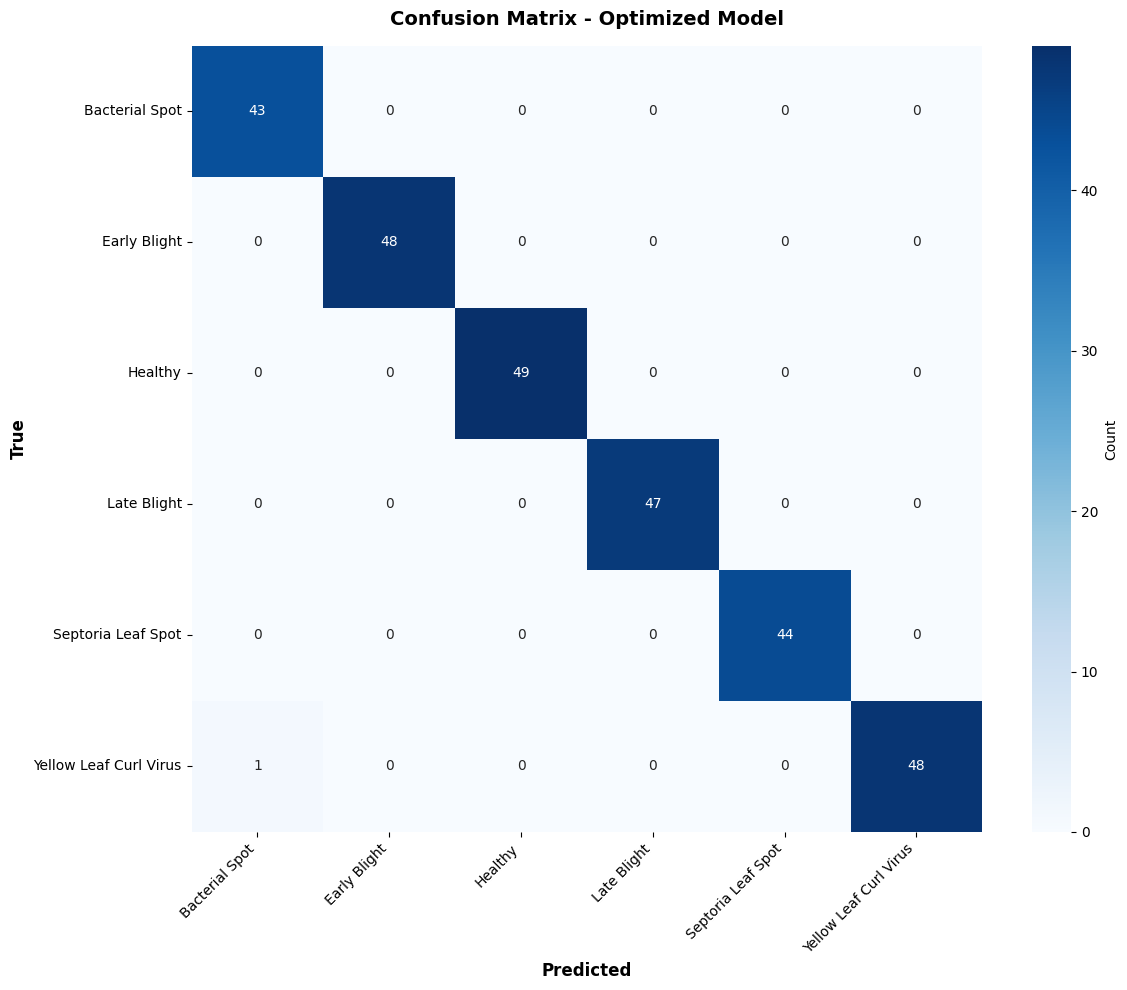


📋 CLASSIFICATION REPORT
                        precision    recall  f1-score   support

        Bacterial Spot     0.9773    1.0000    0.9885        43
          Early Blight     1.0000    1.0000    1.0000        48
               Healthy     1.0000    1.0000    1.0000        49
           Late Blight     1.0000    1.0000    1.0000        47
    Septoria Leaf Spot     1.0000    1.0000    1.0000        44
Yellow Leaf Curl Virus     1.0000    0.9796    0.9897        49

              accuracy                         0.9964       280
             macro avg     0.9962    0.9966    0.9964       280
          weighted avg     0.9965    0.9964    0.9964       280



In [12]:
# Dự đoán trên test set
y_pred = []
y_true = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('True', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - Optimized Model', fontsize=14, fontweight='bold', pad=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification Report
print("\n" + "="*80)
print("📋 CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
print("="*80)

## 11. PHÂN TÍCH CHI TIẾT TỪNG CLASS

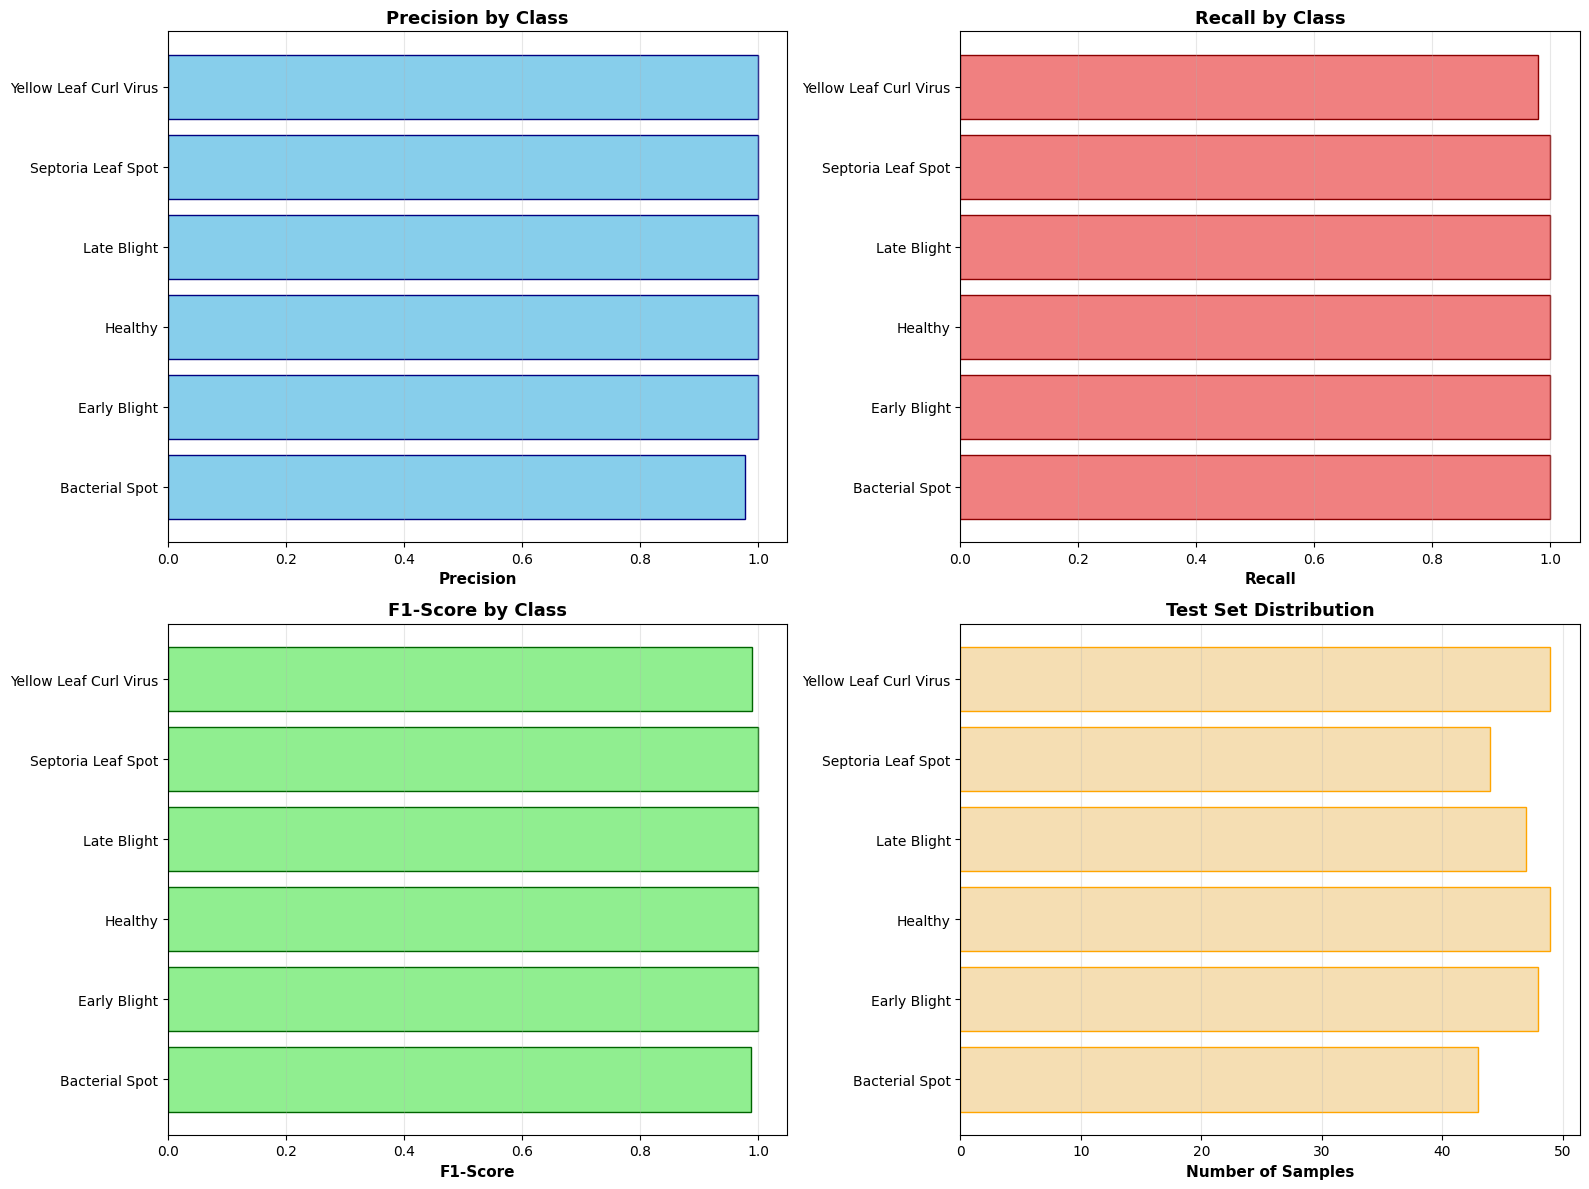


📊 PER-CLASS PERFORMANCE SUMMARY
Class                           Precision     Recall   F1-Score    Support
--------------------------------------------------------------------------------
Bacterial Spot                     0.9773     1.0000     0.9885         43
Early Blight                       1.0000     1.0000     1.0000         48
Healthy                            1.0000     1.0000     1.0000         49
Late Blight                        1.0000     1.0000     1.0000         47
Septoria Leaf Spot                 1.0000     1.0000     1.0000         44
Yellow Leaf Curl Virus             1.0000     0.9796     0.9897         49
AVERAGE                            0.9962     0.9966     0.9964        280


In [13]:
from sklearn.metrics import precision_recall_fscore_support

# Tính metrics cho từng class
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, average=None, labels=range(num_classes)
)

# Vẽ biểu đồ so sánh
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Precision
axes[0, 0].barh(class_names, precision, color='skyblue', edgecolor='navy')
axes[0, 0].set_xlabel('Precision', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Precision by Class', fontsize=13, fontweight='bold')
axes[0, 0].set_xlim([0, 1.05])
axes[0, 0].grid(axis='x', alpha=0.3)

# Recall
axes[0, 1].barh(class_names, recall, color='lightcoral', edgecolor='darkred')
axes[0, 1].set_xlabel('Recall', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Recall by Class', fontsize=13, fontweight='bold')
axes[0, 1].set_xlim([0, 1.05])
axes[0, 1].grid(axis='x', alpha=0.3)

# F1-Score
axes[1, 0].barh(class_names, f1, color='lightgreen', edgecolor='darkgreen')
axes[1, 0].set_xlabel('F1-Score', fontsize=11, fontweight='bold')
axes[1, 0].set_title('F1-Score by Class', fontsize=13, fontweight='bold')
axes[1, 0].set_xlim([0, 1.05])
axes[1, 0].grid(axis='x', alpha=0.3)

# Support
axes[1, 1].barh(class_names, support, color='wheat', edgecolor='orange')
axes[1, 1].set_xlabel('Number of Samples', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Test Set Distribution', fontsize=13, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# In bảng tổng hợp
print("\n" + "="*80)
print("📊 PER-CLASS PERFORMANCE SUMMARY")
print("="*80)
print(f"{'Class':<30} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'Support':>10}")
print("-"*80)
for i, class_name in enumerate(class_names):
    print(f"{class_name:<30} {precision[i]:>10.4f} {recall[i]:>10.4f} {f1[i]:>10.4f} {support[i]:>10}")
print("="*80)
print(f"{'AVERAGE':<30} {np.mean(precision):>10.4f} {np.mean(recall):>10.4f} {np.mean(f1):>10.4f} {np.sum(support):>10}")
print("="*80)